# Homework 5 Q2
#### Michael Kupperman

Eigenvectors, power iterations, and randomized linear algebra

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sys
import scipy.io as scio
import os
import scipy
import imageio

np.set_printoptions(threshold=sys.maxsize)
np.set_printoptions(edgeitems=10)
np.core.arrayprint._line_width = 300

In [2]:
# Optional - set width to 100% of screen (- buffer). Good for laptops, bad for ultrawides
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

## 2. Yale Faces 
Download the Yale Faces Data



In [3]:
cropped_dir = 'Data/CroppedYale/yaleB'
cropped_files = []
for idx in range(1,40):
    tmp = ''
    if idx < 10:
        tmp = '0'
    tmp += str(idx)
    crop_dir = cropped_dir + tmp
    if not os.path.isdir(crop_dir):
        continue
    cropped_files.append([])
    for im in [file for file in os.listdir(crop_dir) if os.path.isfile(os.path.join(crop_dir, file))]:
        #print(im[-1])
        #if im[-1] != 'd':
        cropped_files[-1].append((imageio.imread(os.path.join(crop_dir, im))) / 255)
        #else:
            #pass
            #print(im)
people_vectors = []
for person in cropped_files:
    flat = []
    for im in person:
        flat.append(im.reshape(im.shape[0] * im.shape[1]))
    people_vectors.append(np.stack(flat, axis=1))
A = np.concatenate(people_vectors, axis=1)
target_shape = cropped_files[0][0].shape

In [4]:
#Collect the data vectors into a matrix
A = np.concatenate(people_vectors, axis=1)

### a)
Power iterate on the matrix of images to find the dominant eigenvector and eigenvalue.  Compare it to the leading order SVD mode.

In [5]:
# Our modified power iteration function - we drop the intermediate values to avoid memory overflows
def power_iter(mat, nsteps, init_guess=None, save_iterates=False):
    """ Perform `nsteps` of power iteration on init_guess using matrix `mat`. 
        If no guess is provided \hat{e}_1 is used instead """
    if init_guess is None:
        init_guess = np.zeros(mat.shape[0])
        init_guess[0] = 1
    #iterates = [init_guess]
    iterates = []
    for idx in range(nsteps):
        v1 = np.dot(mat, init_guess) 
        init_guess = v1 / np.linalg.norm(v1)
        eigenvector = np.dot(init_guess, np.dot(mat, init_guess))
        iterates.append(eigenvector.copy())
    if save_iterates:
        return init_guess, eigenvector, iterates
    else:
        return init_guess, eigenvector

In [41]:
cormat_AV = A.T @ A  # as A is real, don't normalize
cormat_AU = A @ A.T
print(cormat_AV.shape, cormat_AU.shape)

(2432, 2432) (32256, 32256)


Let's compute the eigenvalue using power iteration and singular value using the numpy's `np.linalg.SVD` command. 

In [42]:
eigvec_V, eigval_V, iterates_V = power_iter(cormat_AV, 50, init_guess=None, save_iterates=True)
eigvec_U, eigval_U, iterates_U = power_iter(cormat_AU, 50, init_guess=None, save_iterates=True)
U, S, V, = np.linalg.svd(A, full_matrices=False)  # only get the first 2414 singular values


In [43]:
#Manual memory cleanup, we don't need these anymore now that we have the SVD and power iterates
if 'cormat_AV' in locals():
    del cormat_AV
if 'cormat_AU' in locals():
    del cormat_AU


In [44]:
eigen_iterates_V = np.sqrt(np.asarray(iterates_V))  # the singular value we're estimating is the square root of the eigenvalue we just calculated
eigen_iterates_U = np.sqrt(np.asarray(iterates_U))  # the singular value we're estimating is the square root of the eigenvalue we just calculated

In [45]:
print(eigen_iterates_U[-1], eigen_iterates_V[-1])
print('The error between the two estimates is', eigen_iterates_U[-1] - eigen_iterates_V[-1])

2747.8967403969414 2747.896740396942
The error between the two estimates is -4.547473508864641e-13


This error may seem large, however also note that this error is the difference of two numbers on the order of $2 \times 10^{3}$, so the error is at machine epsilon precision after catastrophic cancellation.

In [46]:
S.shape  # Check how many singular values we pulled out

(2432,)

In [47]:
print('The largest singular value is', S[0])  # Get the leading singular value
print('The error of the singular value estimate from the A^T A is', np.abs(S[0] - eigen_iterates_V[-1]))
print('The error of the singular value estimate from the A A^T is', np.abs(S[0] - eigen_iterates_U[-1]))

The largest singular value is 2747.896740396943
The error of the singular value estimate from the A^T A is 1.3642420526593924e-12
The error of the singular value estimate from the A A^T is 1.8189894035458565e-12


We were able to exactly capture the singular value to format precision power-iterating for the smaller matrix with the eigenvalue. 
However power-iterating the larger matrix (32 thousand by 32 thousand) does not give the correct eigenvalue. This error is a result of the numerical error from the dense matrix multipication. 

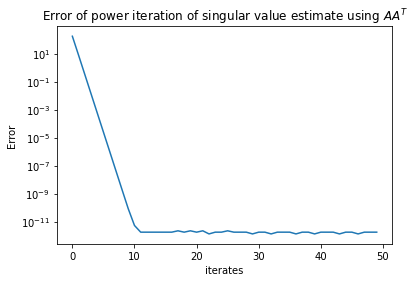

In [48]:
plt.plot(np.abs(eigen_iterates_U - S[0]))
plt.yscale('log')
plt.xlabel('iterates')
plt.ylabel('Error')
#plt.title('Error of Power iteration')
plt.title('Error of power iteration of singular value estimate using $A A^T$')
plt.savefig('Figures/fig1.eps')
plt.show()

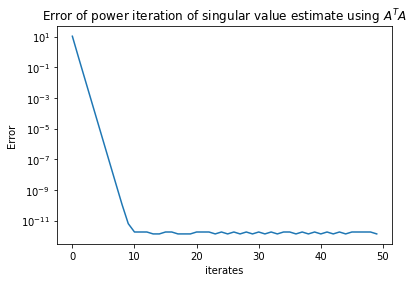

In [49]:
plt.plot(np.abs(eigen_iterates_V - S[0]))
plt.yscale('log')
plt.xlabel('iterates')
plt.ylabel('Error')
#plt.title('Error of Power iteration')
plt.title('Error of power iteration of singular value estimate using $A^T A$')
plt.savefig('Figures/fig2.eps')

plt.show()

Let's examine the eigenvectors.

The eigenvector is a 2414 dimensional vector and appears identical to the one found by the SVG, but is in the opposite direction (so we can multiply by $-1$ to align the directions) - we'll visualize this first. 

In [50]:
U.shape

(32256, 2432)

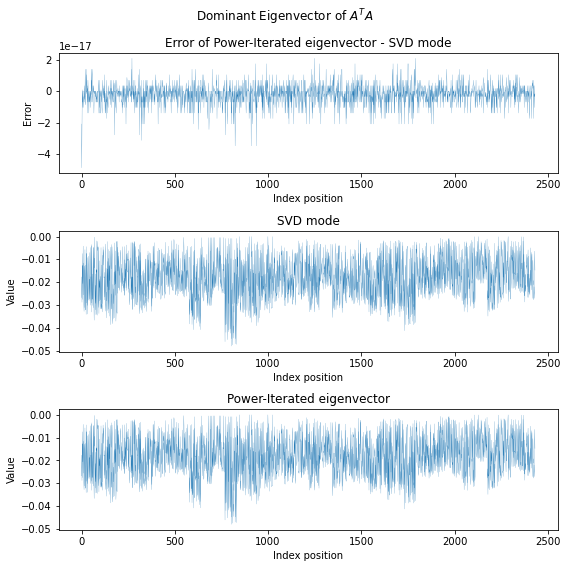

In [70]:
eigvec_n = -1 * eigvec_V
eigvec_nV = -1 * eigvec_V

fig, ax = plt.subplots(3,1, figsize=(8,8))
ax[0].plot(np.arange(eigvec_n.shape[0]), V[0,:] - eigvec_n, linewidth=0.2)
ax[0].set_xlabel('Index position')
ax[0].set_ylabel('Error')
ax[0].set_title('Error of Power-Iterated eigenvector - SVD mode')

ax[1].plot(np.arange(eigvec_n.shape[0]), V[0, :], linewidth=0.2)
ax[1].set_xlabel('Index position')
ax[1].set_ylabel('Value')
ax[1].set_title('SVD mode')

ax[2].plot(np.arange(eigvec_n.shape[0]), eigvec_n, linewidth=0.2)
ax[2].set_xlabel('Index position')
ax[2].set_ylabel('Value')
ax[2].set_title('Power-Iterated eigenvector')
fig.suptitle('Dominant Eigenvector of $A^T A$')
fig.tight_layout()
plt.savefig('Figures/fig3.eps')

plt.show()

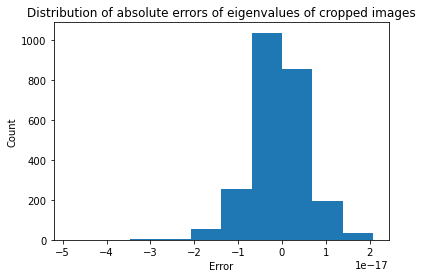

In [59]:
plt.hist(V[0,:] - eigvec_n)
plt.xlabel('Error')
plt.ylabel('Count')
plt.title('Distribution of absolute errors of eigenvalues of cropped images')
plt.savefig('Figures/fig4.eps')

plt.show()

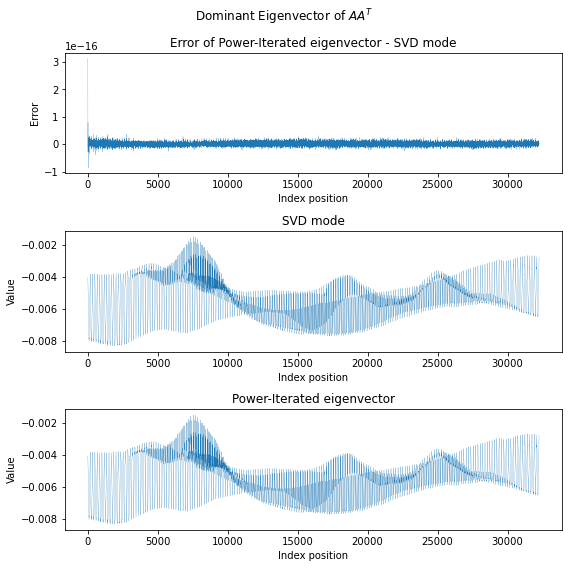

In [61]:
eigvec_n = -1 * eigvec_U
eigvec_nU = -1 * eigvec_U

fig, ax = plt.subplots(3,1, figsize=(8,8))
ax[0].plot(np.arange(eigvec_n.shape[0]), U[:,0] - eigvec_n, linewidth=0.2)
ax[0].set_xlabel('Index position')
ax[0].set_ylabel('Error')
ax[0].set_title('Error of Power-Iterated eigenvector - SVD mode')

ax[1].plot(np.arange(eigvec_n.shape[0]), U[:,0], linewidth=0.2)
ax[1].set_xlabel('Index position')
ax[1].set_ylabel('Value')
ax[1].set_title('SVD mode')

ax[2].plot(np.arange(eigvec_n.shape[0]), eigvec_n, linewidth=0.2)
ax[2].set_xlabel('Index position')
ax[2].set_ylabel('Value')
ax[2].set_title('Power-Iterated eigenvector')
fig.suptitle('Dominant Eigenvector of $A A^T$')
fig.tight_layout()
plt.savefig('Figures/fig5.eps')

plt.show()

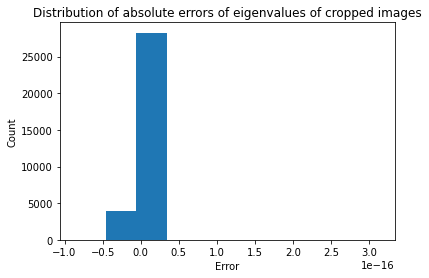

In [54]:
plt.hist(U[:,0] - eigvec_nU)
plt.xlabel('Error')
plt.ylabel('Count')
plt.title('Distribution of absolute errors of eigenvalues of cropped images')
plt.savefig('Figures/fig6.eps')

plt.show()

The errors are very small.

We can compute the 1st mode of the SVD using the power iteration and the SVD output.

In [62]:
 eigvec_nU.T.shape

(32256,)

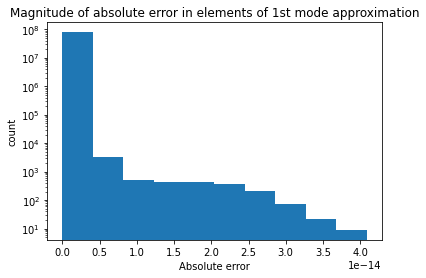

In [72]:
mode_1p = np.outer(eigvec_nU, eigvec_nV) * np.sqrt(eigval_V)  # eigval_V is more accurate
mode_1n = np.outer(U[:,0], V[0,:]) * S[0]
error = mode_1p - mode_1n
plt.hist(np.abs(error).flatten(), log=True)
plt.xlabel('Absolute error')
plt.ylabel('count')
plt.title('Magnitude of absolute error in elements of 1st mode approximation')
plt.savefig('Figures/fig7.eps')
plt.show()

We got a good reconstruction of the 1st mode! The errors are less than $4 \times 10^{-14}$ for almost all positions. Considering that the original data is compressed into a `[0,1]` interval and represents an 8-bit grayscale color, the mode error is sufficiently small for any application.

### b)
Use randomized sampling to reproduce the SVD matrices: $U$, $S$, $V$.

In [35]:
k = 2432  # Specificy dimensions for some low dimensional subspace

def rSVD(mat, k):
    rng = np.random.default_rng()
    Omega = rng.standard_normal(k * mat.shape[1]).reshape(mat.shape[1], k)
    Y = mat @ Omega
    Q, R = np.linalg.qr(Y)
    B = Q.T @ mat
    Uh, Sh, Vh = np.linalg.svd(B)
    U = Q @ Uh
    return U, Sh, Vh

In [36]:
U, S, V = rSVD(A, k)
print(U.shape)

(32256, 2432)


In [37]:
Ue, Se, Ve = np.linalg.svd(A, full_matrices=False)

In [38]:
Uerror = Ue - U

Let's use the full number of columns to get all modes. We'll look at the U matrix reconstruction.

In [39]:
avg_error = np.average(Uerror)
print(avg_error)

print('The probability that a random element of U has an approximation error less than 10 ** -14 is', 
      np.sum(np.where(Uerror < (10 ** -14), 1, 0)) / (Uerror.shape[0] * Uerror.shape[1]))  # pretty good!

-4.781470760461571e-06
The probability that a random element of U has an approximation error less than 10 ** -14 is 0.9037296610667294


### c)

Compare the randomized modes to the true modes along with the singular value decay as a function of the number of randomized samples. 

We'll compare the probability that the error in our mode-1 approximation is less than some thresholds $1 \times 10^{-10}$, $1 \times 10^{-12}$, and $1 \times 10^{-14}$ to determime the quality of the approximation. We'll also track the median error. 

In [84]:
thhold = [10 ** -6, 10 ** -10, 10 ** -14]
#1 * 10 ** -14
mode_error_cutoffs_low = []  # percentage of entries in mode-1 that are accurate to the error threshhold
mode_error_cutoffs_med = []  # percentage of entries in mode-1 that are accurate to the error threshhold
mode_error_cutoffs_hig = []  # percentage of entries in mode-1 that are accurate to the error threshhold
median_error = []
k_vals = []
sv_list = []
mode_1_true = np.outer(Ue[:, 0], Ve[0,:]) * Se[0]
for k in range(1, 500):
    k_vals.append(k)
    U, S, V = rSVD(A, k)
    sv_list.append(S.copy())
    mode_1n = np.outer(U[:, 0], V[0,:]) * S[0]
    errors = mode_1_true - mode_1n
    mode_error_cutoffs_low.append(np.sum(np.where(errors < (thhold[0]), 1, 0)) / (Uerror.shape[0] * Uerror.shape[1]))
    mode_error_cutoffs_med.append(np.sum(np.where(errors < (thhold[1]), 1, 0)) / (Uerror.shape[0] * Uerror.shape[1]))
    mode_error_cutoffs_hig.append(np.sum(np.where(errors < (thhold[2]), 1, 0)) / (Uerror.shape[0] * Uerror.shape[1]))
    median_error.append(np.median(np.abs(errors).flatten()))

In [74]:
#mode_error_cutoffs

In [75]:
#median_error

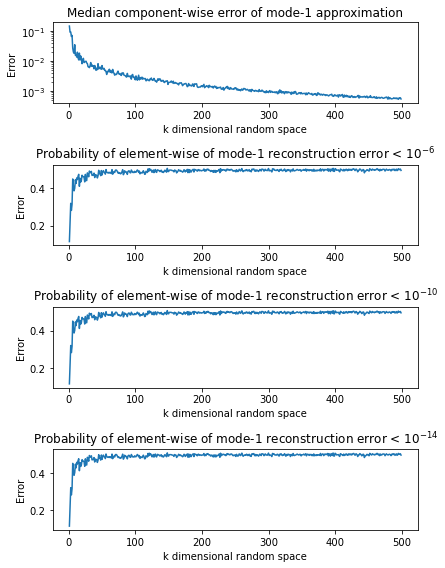

In [89]:
fig, ax = plt.subplots(4, figsize=(6,8))

ax[0].plot(k_vals, median_error)
ax[0].set_xlabel('k dimensional random space')
ax[0].set_title('Median component-wise error of mode-1 approximation')
ax[0].set_ylabel('Error')
ax[0].set_yscale('log')

ax[1].plot(k_vals, mode_error_cutoffs_low)
ax[1].set_xlabel('k dimensional random space')
ax[1].set_title('Probability of element-wise of mode-1 reconstruction error < $10^{-6}$')
ax[1].set_ylabel('Error')

ax[2].plot(k_vals, mode_error_cutoffs_med)
ax[2].set_xlabel('k dimensional random space')
ax[2].set_title('Probability of element-wise of mode-1 reconstruction error < $10^{-10}$')
ax[2].set_ylabel('Error')

ax[3].plot(k_vals, mode_error_cutoffs_hig)
ax[3].set_xlabel('k dimensional random space')
ax[3].set_title('Probability of element-wise of mode-1 reconstruction error < $10^{-14}$')
ax[3].set_ylabel('Error')
fig.tight_layout()
plt.savefig('Figures/fig8.eps')
plt.show()

As we see, the median error continues to decrease as we increase $k$. However, as the last 3 plots show, the number of elements in the mode-1 approximation that have very small error doesn't improve after $k\approx 75$. 

Let's look at the singualr value decay of the approximations.

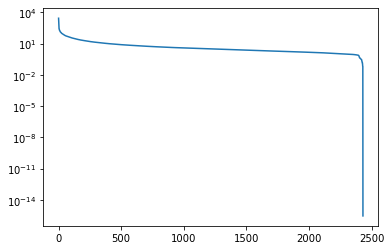

In [77]:
plt.plot(np.arange(Se.shape[0]), Se)
plt.yscale('log')

Let's look at the first 200 singular values.

In [78]:
U, S, V = rSVD(A, 200)  # get an approximation for k=200

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


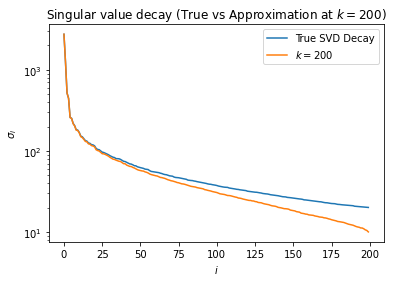

In [79]:
plt.plot(np.arange(200), Se[0:200], np.arange(200), S)
plt.legend(['True SVD Decay', '$k=200$'])
plt.yscale('log')
plt.xlabel('$i$')
plt.ylabel('$\sigma_i$')
plt.title('Singular value decay (True vs Approximation at $k=200$)')
plt.savefig('Figures/fig9.eps')
plt.show()

Text(0, 0.5, '$\\sigma_i$')

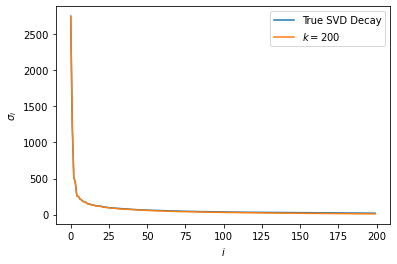

In [80]:
plt.plot(np.arange(200), Se[0:200], np.arange(200), S)
plt.legend(['True SVD Decay', '$k=200$'])
plt.xlabel('$i$')
plt.ylabel('$\sigma_i$')

The approximation is quite good, however there is more error in the smaller singular values. We captured the first $\approx 20$ singular values very well. Let's compare the singular value decay for the first 50 singular values as a function of $k$. 

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


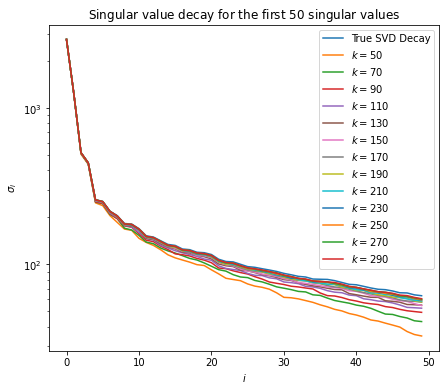

In [90]:
num_sv = 50
plt.plot(np.arange(num_sv), Se[0:num_sv])
legend_list = ['True SVD Decay']
for idx in range(num_sv, 6 * (num_sv), 20):
    plt.plot(np.arange(num_sv), sv_list[idx][0:num_sv])
    legend_list.append('$k=' + str(idx) + '$' )
plt.legend(legend_list)
fig = plt.gcf()
fig.set_size_inches(7,6)
plt.yscale('log')
plt.xlabel('$i$')
plt.title('Singular value decay for the first $50$ singular values')
plt.ylabel('$\sigma_i$')
plt.savefig('Figures/fig10.eps')
plt.show()

The error ($\sigma_i - \hat{\sigma}_i$) plot is much more insightful. Interestingly, all singular values we find are under-approximations, not over-approximations. This may be impacted by the random matrix $\Omega$ used during rSVD calculations. 

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


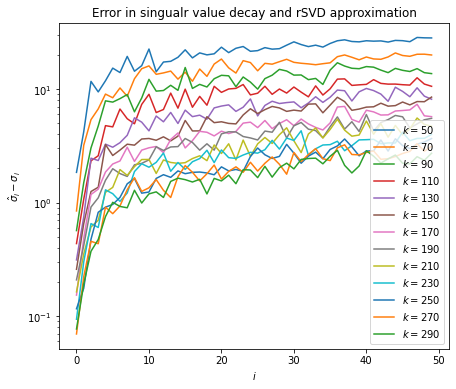

In [91]:
# Let's look at the errors
#plt.plot(np.arange(num_sv), Se[0:num_sv])
legend_list = []
for idx in range(num_sv, 6 * (num_sv), 20):
    plt.plot(np.arange(num_sv),Se[0:num_sv] - sv_list[idx][0:num_sv])
    legend_list.append('$k=' + str(idx) + '$' )
plt.legend(legend_list)
fig = plt.gcf()
fig.set_size_inches(7,6)
plt.yscale('log')
plt.xlabel('$i$')
plt.title('Error in singualr value decay and rSVD approximation')
plt.ylabel('$\hat{\sigma}_i - \sigma_i$')
plt.savefig('Figures/fig11.eps')
plt.show()

The singular value decay is stronger in the approximation than in the true matrix and attains a larger error for small $k$. 

As we increase $k$, the approximation improves in quality and the error of later singular values decreases. (This is nonlinear, according to the plot)